In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from lib.data import generate_top_n_for_all_users, get_ratings, get_predictions, get_top_n, get_relevant_items_for_user, set_items, get_users, set_ratings, set_predictions

# Metric Imports
from lib.availability import availability_for_user
from lib.coverage import is_user_covered, category_coverage_for_user
from lib.diversity import intralist_price_diversity_for_user, intralist_category_diversity_for_user
from lib.mrr import mrr_for_user
from lib.precision import average_precision_for_user, f1_score
from lib.rmse import rmse_for_user
from lib.serendipity import serendipity_for_user
from lib.ndcg import ndcg

from lib.utils import read_items_from_file, read_ratings_from_file, read_predictions_from_file, calculate_statistics, generate_output_files

In [2]:
ALGORITHMS = ['item-item', 'cbf', 'mf', 'user-user', 'weight_cbf_mf_10', 'weight_cbf_mf_25', 'weight_cbf_mf_50', 'weight_cbf_mf_75', 'weight_cbf_mf_85', 'weight_cbf_mf_95', 'weight_cbf_item-item_10', 'weight_cbf_item-item_25', 'weight_cbf_item-item_50', 'weight_cbf_item-item_75', 'weight_cbf_item-item_85', 'weight_cbf_item-item_95']

SINGLEVALUE_METRICS = ['Coverage.Item', 'Coverage.User']
MULTIVALUE_METRICS = ['Availability', 'MRR', 'Serendipity',
                    'MAP', 'RMSE.Predict', 'RMSE.TopN', 'nDCG', 'Diversity.Price', 'Diversity.Category', 'F1']

set_ratings(read_ratings_from_file())
ITEMS = read_items_from_file()
set_items(ITEMS)
ALL_CATEGORIES = set(map(lambda x: x['Category'], ITEMS))

results = {}

for metric in (SINGLEVALUE_METRICS + MULTIVALUE_METRICS):
  results[metric] = {}

for algorithm in ALGORITHMS:
  predictions = read_predictions_from_file(algorithm)
  set_predictions(predictions)

  users = get_users()
  generate_top_n_for_all_users(users)

  items_recommended = set()
  users_covered = 0.0

  availability_values = []
  mrr_values = []
  serendipity_values = []
  map_values = []
  f1_values = []
  rmse_predict_values = []
  rmse_top_values = []
  ndcg_values = []
  diversity_price_values = []
  diversity_category_values = []

  for user_id in users:
    top_n = get_top_n(user_id, 5)
    user_ratings = get_ratings(user_id)
    user_relevant_items = get_relevant_items_for_user(user_id)
    user_predictions = get_predictions(user_id)

    # Coverage Metrics
    items_recommended = items_recommended | set(top_n['Item'])

    if is_user_covered(top_n):
      users_covered += 1.0

    # Other metrics
    availability_values.append(availability_for_user(top_n))
    mrr_values.append(mrr_for_user(top_n, user_relevant_items))
    serendipity_values.append(serendipity_for_user(top_n, user_id))
    map_values.append(average_precision_for_user(top_n, user_id))
    f1_values.append(f1_score(top_n, user_id))
    rmse_predict = rmse_for_user(user_id, user_ratings, user_predictions)
    rmse_predict_values.append(rmse_predict)
    rmse_top_n = rmse_for_user(user_id, user_ratings, top_n)
    rmse_top_values.append(rmse_top_n)
    ndcg_values.append(ndcg(user_id, top_n))
    diversity_price_values.append(intralist_price_diversity_for_user(top_n))
    diversity_category_values.append(intralist_category_diversity_for_user(top_n))

  results['Availability'][algorithm] = calculate_statistics(availability_values, algorithm)
  results['MRR'][algorithm] = calculate_statistics(mrr_values, algorithm)
  results['Serendipity'][algorithm] = calculate_statistics(serendipity_values, algorithm)
  results['MAP'][algorithm] = calculate_statistics(map_values, algorithm)
  results['F1'][algorithm] = calculate_statistics(f1_values, algorithm)
  results['RMSE.Predict'][algorithm] = calculate_statistics(rmse_predict_values, algorithm)
  results['RMSE.TopN'][algorithm] = calculate_statistics(rmse_top_values, algorithm)
  results['nDCG'][algorithm] = calculate_statistics(ndcg_values, algorithm)
  results['Diversity.Price'][algorithm] = calculate_statistics(diversity_price_values, algorithm)
  results['Diversity.Category'][algorithm] = calculate_statistics(diversity_category_values, algorithm)

  results['Coverage.Item'][algorithm] = [float(len(items_recommended))/float(len(ITEMS))]
  results['Coverage.User'][algorithm] = [users_covered/float(len(users))]

results['Availability'] = pd.concat([results['Availability'][algorithm] for algorithm in ALGORITHMS])
results['MRR'] = pd.concat([results['MRR'][algorithm] for algorithm in ALGORITHMS])
results['Serendipity'] = pd.concat([results['Serendipity'][algorithm] for algorithm in ALGORITHMS])
results['MAP'] = pd.concat([results['MAP'][algorithm] for algorithm in ALGORITHMS])
results['F1'] = pd.concat([results['F1'][algorithm] for algorithm in ALGORITHMS])
results['RMSE.Predict'] = pd.concat([results['RMSE.Predict'][algorithm] for algorithm in ALGORITHMS])
results['RMSE.TopN'] = pd.concat([results['RMSE.TopN'][algorithm] for algorithm in ALGORITHMS])
results['nDCG'] = pd.concat([results['nDCG'][algorithm] for algorithm in ALGORITHMS])
results['Diversity.Price'] = pd.concat([results['Diversity.Price'][algorithm] for algorithm in ALGORITHMS])
results['Diversity.Category'] = pd.concat([results['Diversity.Category'][algorithm] for algorithm in ALGORITHMS])

In [3]:
width = 12 # inch
aspect = 0.8 # height/width ratio
height = width*aspect
plt.rcParams['figure.figsize'] = [width, height]

n_groups = 1
index = np.arange(n_groups)
bar_width = 0.35

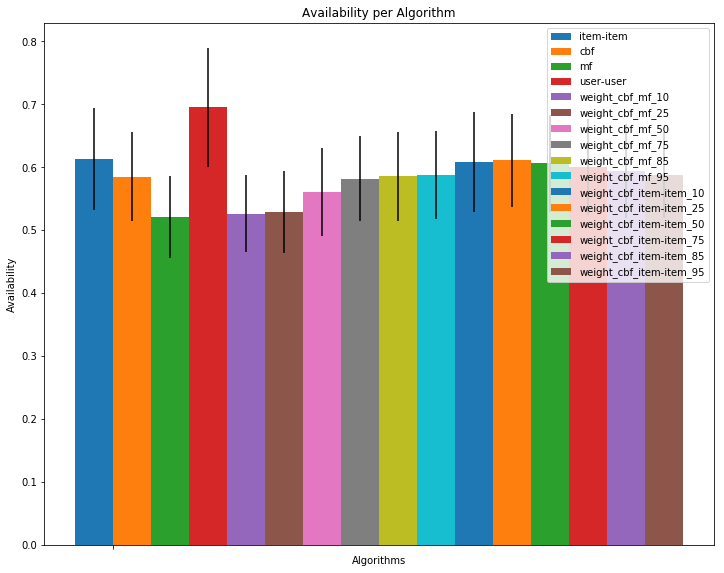

In [4]:
metric = results['Availability']

fig, ax = plt.subplots()

for i in range(0, len(ALGORITHMS)):
    algorithm = ALGORITHMS[i]
    bar = ax.bar(index + i*bar_width, metric.loc[algorithm]['mean'], 
                 width=bar_width, yerr=metric.loc[algorithm]['std'], label=algorithm, tick_label='')
    

ax.set_xlabel('Algorithms')
ax.set_ylabel('Availability')
ax.set_title('Availability per Algorithm')
ax.set_xticks(index + bar_width / 2)
ax.legend()

plt.show()

In [5]:
metric

,10,25,50,75,99,max,mean,min,std
item-item,0.521144,0.558256,0.602912,0.665957,0.818278,0.825452,0.613373,0.453350,0.081052
cbf,0.510899,0.532006,0.566868,0.623718,0.796855,0.802512,0.585363,0.480483,0.070753
mf,0.468187,0.468187,0.498603,0.564393,0.684572,0.684572,0.521616,0.468187,0.065243
user-user,0.567862,0.624114,0.688028,0.761760,0.908394,0.918805,0.695152,0.500692,0.094819
weight_cbf_mf_10,0.468187,0.477941,0.498603,0.564393,0.684572,0.684572,0.526142,0.468187,0.061492
weight_cbf_mf_25,0.468187,0.481192,0.498603,0.564393,0.684572,0.684572,0.529362,0.455917,0.065323
weight_cbf_mf_50,0.485819,0.498603,0.549552,0.616547,0.728618,0.762933,0.561319,0.450936,0.069711
weight_cbf_mf_75,0.510611,0.530222,0.566868,0.624194,0.731425,0.802512,0.582192,0.450936,0.067238
weight_cbf_mf_85,0.510739,0.529548,0.566868,0.624356,0.796855,0.802512,0.585662,0.459633,0.071057
weight_cbf_mf_95,0.510899,0.535748,0.566868,0.624194,0.796855,0.802512,0.587963,0.480483,0.069491


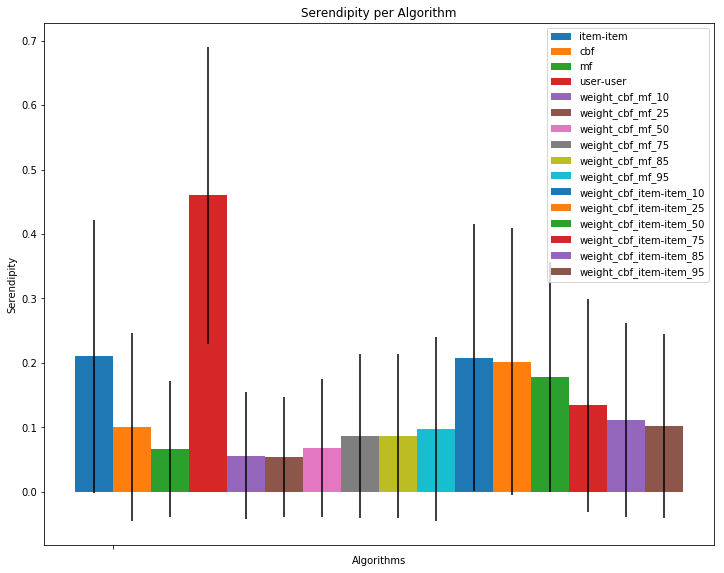

In [6]:
metric = results['Serendipity']

fig, ax = plt.subplots()

for i in range(0, len(ALGORITHMS)):
    algorithm = ALGORITHMS[i]
    bar = ax.bar(index + i*bar_width, metric.loc[algorithm]['mean'], 
                 width=bar_width, yerr=metric.loc[algorithm]['std'], label=algorithm, tick_label='')
    

ax.set_xlabel('Algorithms')
ax.set_ylabel('Serendipity')
ax.set_title('Serendipity per Algorithm')
ax.set_xticks(index + bar_width / 2)
ax.legend()

plt.show()

In [7]:
metric

,10,25,50,75,99,max,mean,min,std
item-item,0.0,0.0,0.2,0.4,0.800,0.8,0.210,0.0,0.212368
cbf,0.0,0.0,0.0,0.2,0.602,0.8,0.100,0.0,0.145602
mf,0.0,0.0,0.0,0.2,0.400,0.4,0.066,0.0,0.106038
user-user,0.2,0.2,0.4,0.6,0.802,1.0,0.460,0.0,0.230651
weight_cbf_mf_10,0.0,0.0,0.0,0.2,0.400,0.4,0.056,0.0,0.098306
weight_cbf_mf_25,0.0,0.0,0.0,0.2,0.202,0.4,0.054,0.0,0.093188
weight_cbf_mf_50,0.0,0.0,0.0,0.2,0.400,0.4,0.068,0.0,0.106658
weight_cbf_mf_75,0.0,0.0,0.0,0.2,0.402,0.6,0.086,0.0,0.127295
weight_cbf_mf_85,0.0,0.0,0.0,0.2,0.402,0.6,0.086,0.0,0.127295
weight_cbf_mf_95,0.0,0.0,0.0,0.2,0.602,0.8,0.098,0.0,0.142815


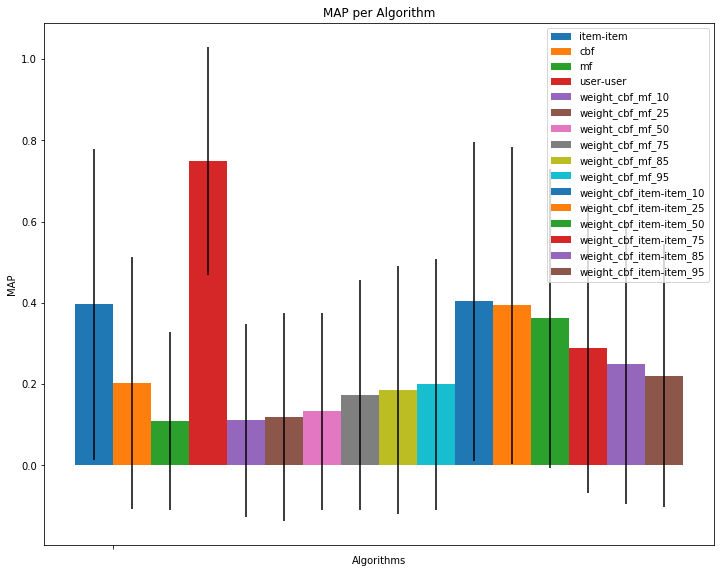

In [8]:
metric = results['MAP']

fig, ax = plt.subplots()

for i in range(0, len(ALGORITHMS)):
    algorithm = ALGORITHMS[i]
    bar = ax.bar(index + i*bar_width, metric.loc[algorithm]['mean'], 
                 width=bar_width, yerr=metric.loc[algorithm]['std'], label=algorithm, tick_label='')
    

ax.set_xlabel('Algorithms')
ax.set_ylabel('MAP')
ax.set_title('MAP per Algorithm')
ax.set_xticks(index + bar_width / 2)
ax.legend()

plt.show()

In [9]:
metric

,10,25,50,75,99,max,mean,min,std
item-item,0.0000,0.000000,0.291667,0.712500,1.0,1.0,0.397000,0.0,0.383009
cbf,0.0000,0.000000,0.000000,0.333333,1.0,1.0,0.202042,0.0,0.310513
mf,0.0000,0.000000,0.000000,0.200000,1.0,1.0,0.109167,0.0,0.218548
user-user,0.3325,0.588889,0.850000,1.000000,1.0,1.0,0.749278,0.0,0.281404
weight_cbf_mf_10,0.0000,0.000000,0.000000,0.000000,1.0,1.0,0.110833,0.0,0.238297
weight_cbf_mf_25,0.0000,0.000000,0.000000,0.200000,1.0,1.0,0.119500,0.0,0.256570
weight_cbf_mf_50,0.0000,0.000000,0.000000,0.250000,1.0,1.0,0.132833,0.0,0.243224
weight_cbf_mf_75,0.0000,0.000000,0.000000,0.325000,1.0,1.0,0.172972,0.0,0.282169
weight_cbf_mf_85,0.0000,0.000000,0.000000,0.325000,1.0,1.0,0.186639,0.0,0.305221
weight_cbf_mf_95,0.0000,0.000000,0.000000,0.333333,1.0,1.0,0.199208,0.0,0.308630


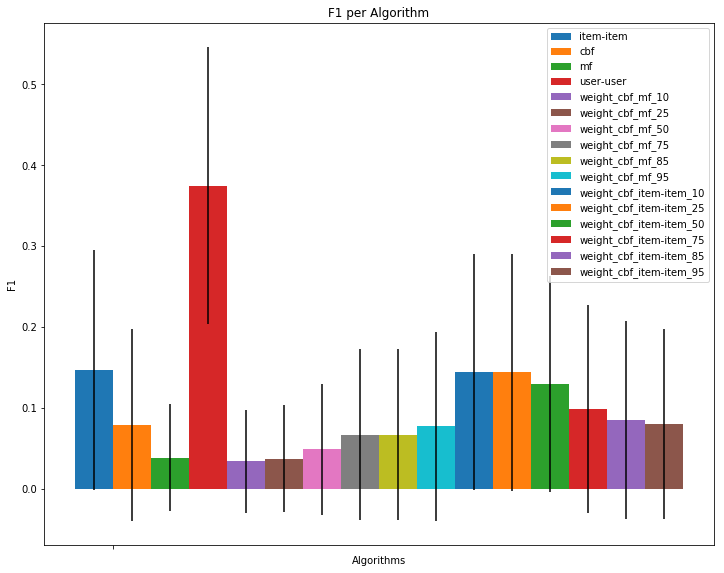

In [10]:
metric = results['F1']

fig, ax = plt.subplots()

for i in range(0, len(ALGORITHMS)):
    algorithm = ALGORITHMS[i]
    bar = ax.bar(index + i*bar_width, metric.loc[algorithm]['mean'], 
                 width=bar_width, yerr=metric.loc[algorithm]['std'], label=algorithm, tick_label='')
    

ax.set_xlabel('Algorithms')
ax.set_ylabel('F1')
ax.set_title('F1 per Algorithm')
ax.set_xticks(index + bar_width / 2)
ax.legend()

plt.show()


In [11]:
metric

,10,25,50,75,99,max,mean,min,std
item-item,0.000000,0.000000,0.142857,0.222222,0.556667,0.666667,0.146948,0.0,0.147872
cbf,0.000000,0.000000,0.000000,0.153846,0.446667,0.666667,0.079245,0.0,0.118720
mf,0.000000,0.000000,0.000000,0.090909,0.200222,0.222222,0.039002,0.0,0.065534
user-user,0.153846,0.246324,0.375000,0.500000,0.728000,0.800000,0.374980,0.0,0.171491
weight_cbf_mf_10,0.000000,0.000000,0.000000,0.000000,0.200222,0.222222,0.034310,0.0,0.063790
weight_cbf_mf_25,0.000000,0.000000,0.000000,0.074405,0.222222,0.222222,0.037202,0.0,0.066076
weight_cbf_mf_50,0.000000,0.000000,0.000000,0.111111,0.333636,0.363636,0.049087,0.0,0.081267
weight_cbf_mf_75,0.000000,0.000000,0.000000,0.142857,0.445000,0.500000,0.067372,0.0,0.106093
weight_cbf_mf_85,0.000000,0.000000,0.000000,0.142857,0.445000,0.500000,0.067372,0.0,0.106093
weight_cbf_mf_95,0.000000,0.000000,0.000000,0.153846,0.446667,0.666667,0.077707,0.0,0.116730


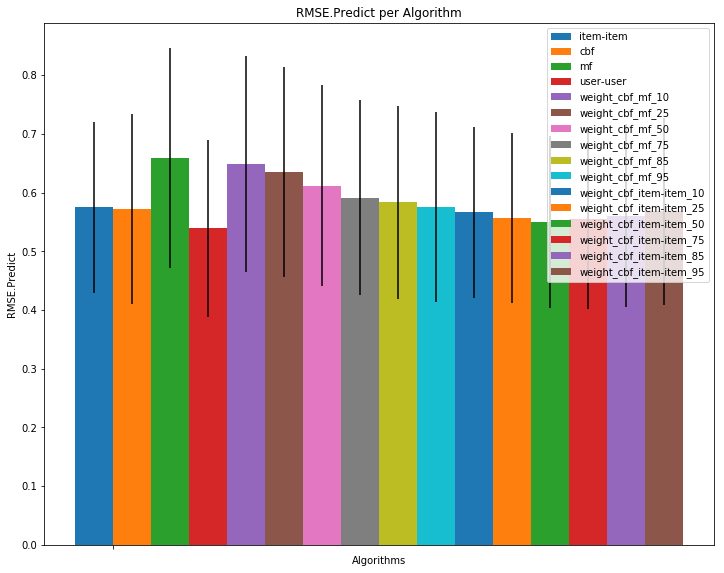

In [12]:
metric = results['RMSE.Predict']

fig, ax = plt.subplots()

for i in range(0, len(ALGORITHMS)):
    algorithm = ALGORITHMS[i]
    bar = ax.bar(index + i*bar_width, metric.loc[algorithm]['mean'], 
                 width=bar_width, yerr=metric.loc[algorithm]['std'], label=algorithm, tick_label='')
    

ax.set_xlabel('Algorithms')
ax.set_ylabel('RMSE.Predict')
ax.set_title('RMSE.Predict per Algorithm')
ax.set_xticks(index + bar_width / 2)
ax.legend()

plt.show()

In [13]:
metric

,10,25,50,75,99,max,mean,min,std
item-item,0.393176,0.488066,0.549393,0.634057,0.992785,1.028632,0.574672,0.335113,0.146474
cbf,0.371323,0.458708,0.565546,0.665676,0.989574,1.017527,0.572387,0.266683,0.161299
mf,0.428535,0.524264,0.638710,0.746580,1.133340,1.258139,0.659029,0.311749,0.187732
user-user,0.379496,0.451870,0.521396,0.608613,0.961865,1.027937,0.539678,0.000000,0.150756
weight_cbf_mf_10,0.424853,0.518230,0.629571,0.736707,1.117635,1.217099,0.649117,0.304594,0.184169
weight_cbf_mf_25,0.418347,0.509630,0.611050,0.722267,1.094521,1.156410,0.634709,0.294811,0.179176
weight_cbf_mf_50,0.396932,0.492264,0.600067,0.698542,1.057264,1.058032,0.612022,0.281326,0.171860
weight_cbf_mf_75,0.379947,0.471207,0.588024,0.681746,1.019980,1.022328,0.591171,0.271808,0.165887
weight_cbf_mf_85,0.377241,0.466446,0.576451,0.673642,1.008974,1.018690,0.583396,0.269212,0.163885
weight_cbf_mf_95,0.373274,0.462856,0.569082,0.668253,0.995959,1.017817,0.575967,0.267341,0.162106


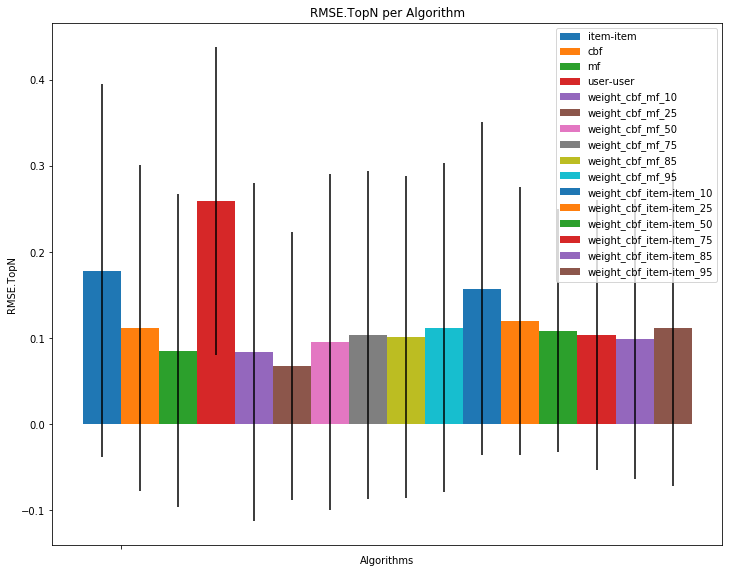

In [14]:
metric = results['RMSE.TopN']

fig, ax = plt.subplots()

for i in range(0, len(ALGORITHMS)):
    algorithm = ALGORITHMS[i]
    bar = ax.bar(index + i*bar_width, metric.loc[algorithm]['mean'], 
                 width=bar_width, yerr=metric.loc[algorithm]['std'], label=algorithm, tick_label='')
    

ax.set_xlabel('Algorithms')
ax.set_ylabel('RMSE.TopN')
ax.set_title('RMSE.TopN per Algorithm')
ax.set_xticks(index + bar_width / 2)
ax.legend()

plt.show()

In [15]:
metric

,10,25,50,75,99,max,mean,min,std
item-item,0.000000,0.000000,0.137183,0.293425,1.095363,1.143694,0.178520,0.0,0.216939
cbf,0.000000,0.000000,0.000000,0.163600,0.641167,0.811303,0.111610,0.0,0.189255
mf,0.000000,0.000000,0.000000,0.057908,0.670296,0.885882,0.085722,0.0,0.181740
user-user,0.055927,0.117116,0.230005,0.399643,0.680138,0.931245,0.259641,0.0,0.179276
weight_cbf_mf_10,0.000000,0.000000,0.000000,0.012524,0.866270,0.930114,0.084247,0.0,0.196639
weight_cbf_mf_25,0.000000,0.000000,0.000000,0.009759,0.579247,0.716766,0.068252,0.0,0.155652
weight_cbf_mf_50,0.000000,0.000000,0.000000,0.080506,0.672317,0.838534,0.095963,0.0,0.195365
weight_cbf_mf_75,0.000000,0.000000,0.000000,0.133392,0.673685,0.824918,0.103905,0.0,0.190666
weight_cbf_mf_85,0.000000,0.000000,0.000000,0.121253,0.660678,0.819472,0.101607,0.0,0.186633
weight_cbf_mf_95,0.000000,0.000000,0.000000,0.161056,0.647670,0.814026,0.112416,0.0,0.191190


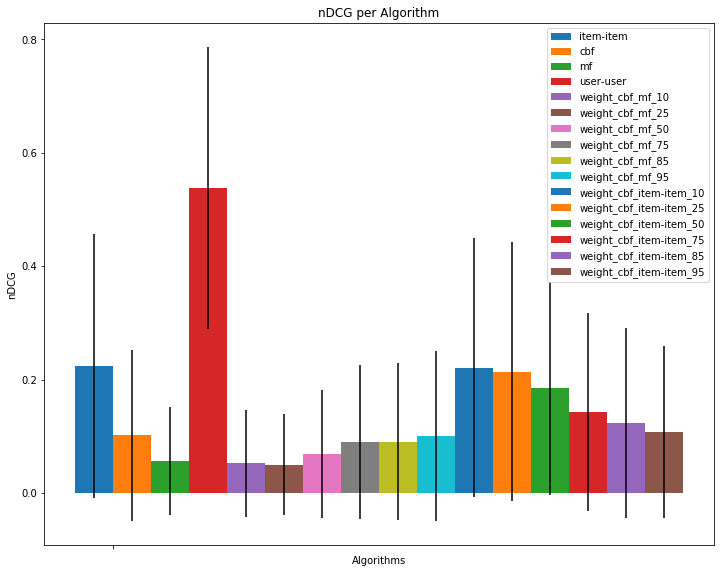

In [16]:
metric = results['nDCG']

fig, ax = plt.subplots()

for i in range(0, len(ALGORITHMS)):
    algorithm = ALGORITHMS[i]
    bar = ax.bar(index + i*bar_width, metric.loc[algorithm]['mean'], 
                 width=bar_width, yerr=metric.loc[algorithm]['std'], label=algorithm, tick_label='')
    

ax.set_xlabel('Algorithms')
ax.set_ylabel('nDCG')
ax.set_title('nDCG per Algorithm')
ax.set_xticks(index + bar_width / 2)
ax.legend()

plt.show()

In [17]:
metric

,10,25,50,75,99,max,mean,min,std
item-item,0.000000,0.000000,0.197405,0.394809,0.880172,1.000000,0.224536,0.0,0.232487
cbf,0.000000,0.000000,0.000000,0.205765,0.518268,0.757924,0.101620,0.0,0.150979
mf,0.000000,0.000000,0.000000,0.121038,0.363126,0.364263,0.057055,0.0,0.095502
user-user,0.242076,0.363114,0.515847,0.732568,1.000000,1.000000,0.538416,0.0,0.248525
weight_cbf_mf_10,0.000000,0.000000,0.000000,0.102882,0.339149,0.363114,0.052190,0.0,0.094525
weight_cbf_mf_25,0.000000,0.000000,0.000000,0.121038,0.243045,0.338907,0.049602,0.0,0.089092
weight_cbf_mf_50,0.000000,0.000000,0.000000,0.152733,0.395703,0.484153,0.068790,0.0,0.112177
weight_cbf_mf_75,0.000000,0.000000,0.000000,0.205765,0.485680,0.636886,0.089331,0.0,0.135695
weight_cbf_mf_85,0.000000,0.000000,0.000000,0.242076,0.485680,0.636886,0.090801,0.0,0.138563
weight_cbf_mf_95,0.000000,0.000000,0.000000,0.205765,0.518268,0.757924,0.100409,0.0,0.149354


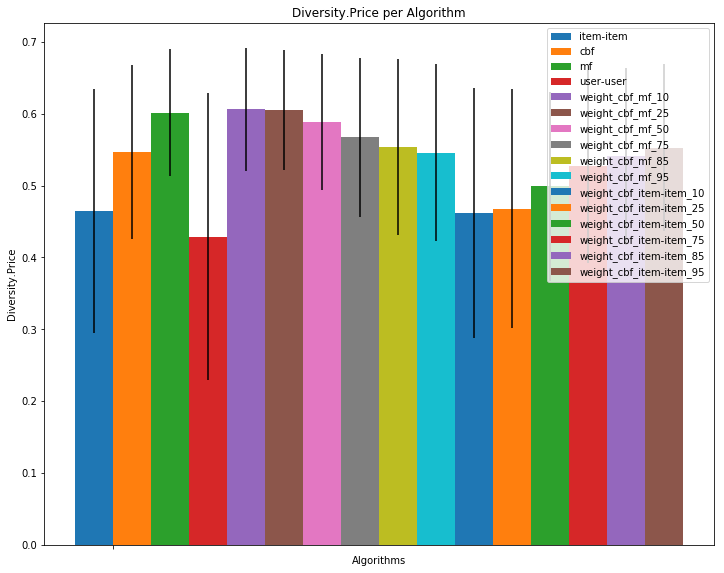

In [18]:
metric = results['Diversity.Price']

fig, ax = plt.subplots()

for i in range(0, len(ALGORITHMS)):
    algorithm = ALGORITHMS[i]
    bar = ax.bar(index + i*bar_width, metric.loc[algorithm]['mean'], 
                 width=bar_width, yerr=metric.loc[algorithm]['std'], label=algorithm, tick_label='')
    

ax.set_xlabel('Algorithms')
ax.set_ylabel('Diversity.Price')
ax.set_title('Diversity.Price per Algorithm')
ax.set_xticks(index + bar_width / 2)
ax.legend()

plt.show()

In [19]:
metric

,10,25,50,75,99,max,mean,min,std
item-item,0.24,0.32,0.48,0.64,0.7200,0.72,0.4648,0.00,0.170344
cbf,0.32,0.48,0.60,0.64,0.7200,0.72,0.5472,0.24,0.121178
mf,0.40,0.64,0.64,0.64,0.6400,0.64,0.6016,0.40,0.087985
user-user,0.16,0.32,0.48,0.56,0.7200,0.72,0.4288,0.00,0.200006
weight_cbf_mf_10,0.40,0.64,0.64,0.64,0.6400,0.64,0.6064,0.32,0.085551
weight_cbf_mf_25,0.40,0.64,0.64,0.64,0.6400,0.64,0.6048,0.32,0.083384
weight_cbf_mf_50,0.40,0.56,0.64,0.64,0.6400,0.64,0.5888,0.32,0.094332
weight_cbf_mf_75,0.40,0.48,0.64,0.64,0.7200,0.72,0.5672,0.24,0.110906
weight_cbf_mf_85,0.32,0.48,0.64,0.64,0.7200,0.72,0.5536,0.16,0.122209
weight_cbf_mf_95,0.32,0.48,0.60,0.64,0.7200,0.72,0.5456,0.24,0.123096


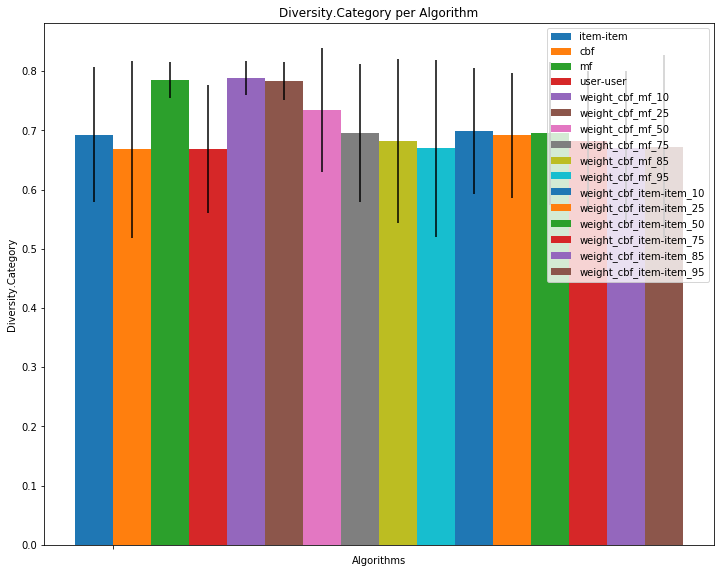

In [20]:
metric = results['Diversity.Category']

fig, ax = plt.subplots()

for i in range(0, len(ALGORITHMS)):
    algorithm = ALGORITHMS[i]
    bar = ax.bar(index + i*bar_width, metric.loc[algorithm]['mean'], 
                 width=bar_width, yerr=metric.loc[algorithm]['std'], label=algorithm, tick_label='')
    

ax.set_xlabel('Algorithms')
ax.set_ylabel('Diversity.Category')
ax.set_title('Diversity.Category per Algorithm')
ax.set_xticks(index + bar_width / 2)
ax.legend()

plt.show()

In [21]:
metric

,10,25,50,75,99,max,mean,min,std
item-item,0.560,0.64,0.72,0.80,0.8,0.8,0.6928,0.32,0.113825
cbf,0.560,0.64,0.72,0.72,0.8,0.8,0.6680,0.00,0.149399
mf,0.720,0.80,0.80,0.80,0.8,0.8,0.7856,0.72,0.030735
user-user,0.560,0.56,0.72,0.72,0.8,0.8,0.6688,0.32,0.108234
weight_cbf_mf_10,0.720,0.80,0.80,0.80,0.8,0.8,0.7880,0.72,0.028566
weight_cbf_mf_25,0.720,0.80,0.80,0.80,0.8,0.8,0.7840,0.72,0.032000
weight_cbf_mf_50,0.632,0.72,0.80,0.80,0.8,0.8,0.7344,0.32,0.105151
weight_cbf_mf_75,0.560,0.72,0.72,0.80,0.8,0.8,0.6960,0.32,0.116207
weight_cbf_mf_85,0.560,0.64,0.72,0.74,0.8,0.8,0.6816,0.00,0.138324
weight_cbf_mf_95,0.560,0.64,0.72,0.72,0.8,0.8,0.6696,0.00,0.149519


In [22]:
pd.DataFrame.from_dict(results['Coverage.Item'])

,cbf,item-item,mf,user-user,weight_cbf_item-item_10,weight_cbf_item-item_25,weight_cbf_item-item_50,weight_cbf_item-item_75,weight_cbf_item-item_85,weight_cbf_item-item_95,weight_cbf_mf_10,weight_cbf_mf_25,weight_cbf_mf_50,weight_cbf_mf_75,weight_cbf_mf_85,weight_cbf_mf_95
0,0.205,0.53,0.045,0.755,0.495,0.445,0.355,0.245,0.215,0.205,0.045,0.07,0.11,0.16,0.185,0.205


In [23]:
pd.DataFrame.from_dict(results['Coverage.User'])

,cbf,item-item,mf,user-user,weight_cbf_item-item_10,weight_cbf_item-item_25,weight_cbf_item-item_50,weight_cbf_item-item_75,weight_cbf_item-item_85,weight_cbf_item-item_95,weight_cbf_mf_10,weight_cbf_mf_25,weight_cbf_mf_50,weight_cbf_mf_75,weight_cbf_mf_85,weight_cbf_mf_95
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
